# Online News Popularity Prediction & Optimization


## 0. Environment & Requirements

Tested on:
- Python 3.13.7
- numpy 2.3.2
- pandas 2.3.2
- matplotlib 3.10.6
- scikit-learn 1.7.2
- joblib 1.5.2
- ucimlrepo 0.0.7

To install dependencies: see 'requirements.txt'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from ucimlrepo import fetch_ucirepo
import joblib
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and preparation

In [ ]:
print("Loading online news popularity dataset:\n")

online_news_popularity = fetch_ucirepo(id=332)
X = online_news_popularity.data.features
y = online_news_popularity.data.targets

print(f"Dataset loaded: {X.shape[0]} articles, {X.shape[1]} features")
print(f"Target shape: {y.shape}")

# Binary classification with D1=1400
D1 = 1400
y_binary = (y.iloc[:, 0] > D1).astype(int)
D2 = 0.5  # Classification decision threshold

print(f"\nBinary classification (D1={D1} shares):")
print(f"  - Unpopular (0): {(y_binary==0).sum()} ({(y_binary==0).sum()/len(y_binary)*100:.1f}%)")
print(f"  - Popular (1): {(y_binary==1).sum()} ({(y_binary==1).sum()/len(y_binary)*100:.1f}%)")

X_processed = X.fillna(X.mean())

Loading online news popularity dataset:

Dataset loaded: 39644 articles, 58 features
Target shape: (39644, 1)

Binary classification (D1=1400 shares):
  - Unpopular (0): 20082 (50.7%)
  - Popular (1): 19562 (49.3%)


## 2. Rolling window setup wih grid search

In [ ]:
print("Setting up rolling window evaluation with grid search\n")

# Rolling window parameters (paper section 3.1)
W = 10000
L = 1000
total_samples = len(X_processed)
num_iterations = (total_samples - W) // L

print(f"Rolling window configuration:")
print(f"  - Training window (W): {W}")
print(f"  - Predictions per iteration (L): {L}")
print(f"  - Total iterations: {num_iterations}")
print(f"  - Total test samples: {num_iterations * L}")

# Hyperparameter grids (paper section 3.1)
param_grids = {
    'RF': ParameterGrid({'n_estimators': [10, 20, 50, 100, 200, 400]}),
    'AdaBoost': ParameterGrid({'n_estimators': [10, 20, 50, 100, 200, 400]}),
    'SVM': ParameterGrid({'C': [2**i for i in range(7)]}),
    'KNN': ParameterGrid({'n_neighbors': [1, 3, 5, 10, 20]}),
    'NB': [{}]
}

all_predictions = {model: {'y_true': [], 'y_pred': [], 'y_proba': []}
                   for model in ['RF', 'AdaBoost', 'SVM', 'KNN', 'NB']}

Setting up rolling window evaluation with grid search

Rolling window configuration:
  - Training window (W): 10000
  - Predictions per iteration (L): 1000
  - Total iterations: 29
  - Total test samples: 29000


## 3. Rolling window evaluation

In [ ]:
for iteration in range(num_iterations): # each iteration trains on W samples, tests on L samples
    start_idx = iteration * L
    train_end_idx = start_idx + W
    test_end_idx = train_end_idx + L

    if test_end_idx > len(X_processed):
        break

    # Extract train/test windows
    X_train = X_processed.iloc[start_idx:train_end_idx]
    y_train = y_binary.iloc[start_idx:train_end_idx]
    X_test = X_processed.iloc[train_end_idx:test_end_idx]
    y_test = y_binary.iloc[train_end_idx:test_end_idx]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #### RANDOM FOREST with grid search
    best_rf_score = 0
    best_rf_params = None
    for params in param_grids['RF']:
        rf = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
        val_split = int(len(X_train_scaled) * 0.7)  # 70/30 split
        rf.fit(X_train_scaled[:val_split], y_train.iloc[:val_split])
        val_score = rf.score(X_train_scaled[val_split:], y_train.iloc[val_split:])
        if val_score > best_rf_score:
            best_rf_score = val_score
            best_rf_params = params

    # Retrain on full training data with best params
    rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    all_predictions['RF']['y_true'].extend(y_test)
    all_predictions['RF']['y_pred'].extend(rf.predict(X_test_scaled))
    all_predictions['RF']['y_proba'].extend(rf.predict_proba(X_test_scaled)[:, 1])

    #### ADABOOST with grid search
    best_ada_score = 0
    best_ada_params = None
    for params in param_grids['AdaBoost']:
        ada = AdaBoostClassifier(**params, random_state=42)
        val_split = int(len(X_train_scaled) * 0.7)
        ada.fit(X_train_scaled[:val_split], y_train.iloc[:val_split])
        val_score = ada.score(X_train_scaled[val_split:], y_train.iloc[val_split:])
        if val_score > best_ada_score:
            best_ada_score = val_score
            best_ada_params = params

    ada = AdaBoostClassifier(**best_ada_params, random_state=42)
    ada.fit(X_train_scaled, y_train)
    all_predictions['AdaBoost']['y_true'].extend(y_test)
    all_predictions['AdaBoost']['y_pred'].extend(ada.predict(X_test_scaled))
    all_predictions['AdaBoost']['y_proba'].extend(ada.predict_proba(X_test_scaled)[:, 1])

    #### SVM (RBF kernel) with grid search
    best_svm_score = 0
    best_svm_params = None
    for params in param_grids['SVM']:
        svm = SVC(kernel='rbf', probability=True, random_state=42, **params)
        val_split = int(len(X_train_scaled) * 0.7)
        try:
            svm.fit(X_train_scaled[:val_split], y_train.iloc[:val_split])
            val_score = svm.score(X_train_scaled[val_split:], y_train.iloc[val_split:])
            if val_score > best_svm_score:
                best_svm_score = val_score
                best_svm_params = params
        except:
            continue

    if best_svm_params is not None:
        svm = SVC(kernel='rbf', probability=True, random_state=42, **best_svm_params)
        try:
            svm.fit(X_train_scaled, y_train)
            all_predictions['SVM']['y_true'].extend(y_test)
            all_predictions['SVM']['y_pred'].extend(svm.predict(X_test_scaled))
            all_predictions['SVM']['y_proba'].extend(svm.predict_proba(X_test_scaled)[:, 1])
        except:
            pass

    #### KNN with grid search
    best_knn_score = 0
    best_knn_params = None
    for params in param_grids['KNN']:
        knn = KNeighborsClassifier(**params)
        val_split = int(len(X_train_scaled) * 0.7)
        knn.fit(X_train_scaled[:val_split], y_train.iloc[:val_split])
        val_score = knn.score(X_train_scaled[val_split:], y_train.iloc[val_split:])
        if val_score > best_knn_score:
            best_knn_score = val_score
            best_knn_params = params

    knn = KNeighborsClassifier(**best_knn_params)
    knn.fit(X_train_scaled, y_train)
    all_predictions['KNN']['y_true'].extend(y_test)
    all_predictions['KNN']['y_pred'].extend(knn.predict(X_test_scaled))
    all_predictions['KNN']['y_proba'].extend(knn.predict_proba(X_test_scaled)[:, 1])

    #### NAIVE BAYES (no hyperparameters)
    nb = GaussianNB()
    nb.fit(X_train_scaled, y_train)
    all_predictions['NB']['y_true'].extend(y_test)
    all_predictions['NB']['y_pred'].extend(nb.predict(X_test_scaled))
    all_predictions['NB']['y_proba'].extend(nb.predict_proba(X_test_scaled)[:, 1])

    if (iteration + 1) % 5 == 0:
        print(f"Completed iteration {iteration + 1}/{num_iterations}")

final_scaler = scaler
rf_final = rf
joblib.dump(rf_final, "rf_final_model.pkl")
joblib.dump(final_scaler, "final_scaler.pkl")

print(f"Total test predictions: {len(all_predictions['RF']['y_true'])}")

Completed iteration 5/29
Completed iteration 10/29
Completed iteration 15/29
Completed iteration 20/29
Completed iteration 25/29
Total test predictions: 29000


## 4. Classification metrics results

In [ ]:
print("Computing classification metrics:")

metrics_table = []
for model_name in ['RF', 'AdaBoost', 'SVM', 'KNN', 'NB']:
    y_true = np.array(all_predictions[model_name]['y_true'])
    y_pred = np.array(all_predictions[model_name]['y_pred'])
    y_proba = np.array(all_predictions[model_name]['y_proba'])

    if len(y_true) == 0:
        continue

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)

    metrics_table.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'AUC': auc
    })

metrics_df = pd.DataFrame(metrics_table).sort_values('AUC', ascending=False)

print("Classification performances:")
print(metrics_df.to_string(index=False))

print("\n\n")

print("Comparison with paper results:")
paper_results = {
    'RF': {'Accuracy': 0.67, 'Precision': 0.67, 'Recall': 0.71, 'F1': 0.69, 'AUC': 0.73},
    'AdaBoost': {'Accuracy': 0.66, 'Precision': 0.68, 'Recall': 0.67, 'F1': 0.67, 'AUC': 0.72},
    'SVM': {'Accuracy': 0.66, 'Precision': 0.67, 'Recall': 0.68, 'F1': 0.68, 'AUC': 0.71},
    'KNN': {'Accuracy': 0.62, 'Precision': 0.66, 'Recall': 0.55, 'F1': 0.60, 'AUC': 0.67},
    'NB': {'Accuracy': 0.62, 'Precision': 0.68, 'Recall': 0.49, 'F1': 0.57, 'AUC': 0.65}
}

for model in ['RF', 'AdaBoost', 'SVM', 'KNN', 'NB']:
    our_auc = metrics_df[metrics_df['Model']==model]['AUC'].values[0] if len(metrics_df[metrics_df['Model']==model]) > 0 else 0
    paper_auc = paper_results[model]['AUC']
    pct = (our_auc / paper_auc * 100) if paper_auc > 0 else 0
    print(f"  {model:12} - Our AUC: {our_auc:.4f}, Paper: {paper_auc:.2f} ({pct:.1f}%)")

Computing classification metrics:
Classification performances:
   Model  Accuracy  Precision   Recall       F1      AUC
      RF  0.663724   0.654610 0.637914 0.646154 0.722725
     SVM  0.655862   0.649955 0.617639 0.633385 0.709216
AdaBoost  0.659897   0.656214 0.616206 0.635581 0.698354
     KNN  0.625828   0.640347 0.507809 0.566428 0.666378
      NB  0.601793   0.652570 0.369251 0.471633 0.647225



Comparison with paper results:
  RF           - Our AUC: 0.7227, Paper: 0.73 (99.0%)
  AdaBoost     - Our AUC: 0.6984, Paper: 0.72 (97.0%)
  SVM          - Our AUC: 0.7092, Paper: 0.71 (99.9%)
  KNN          - Our AUC: 0.6664, Paper: 0.67 (99.5%)
  NB           - Our AUC: 0.6472, Paper: 0.65 (99.6%)


## 5. Feature importance analysis

In [ ]:
print("Computing feature importance (RF on full dataset):")

# Train RF on full data
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_processed)
rf_full = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_full.fit(X_scaled_full, y_binary)

# Feature importances
feature_importance = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': rf_full.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance['Rank'] = range(1, len(feature_importance) + 1)

print("Top 15 Features by Importance (RF Model)")
print(feature_importance[['Rank', 'Feature', 'Importance']].head(15).to_string(index=False))

# Identify optimizable features
keyword_features = [i for i, col in enumerate(X_processed.columns) if 'keyword' in col.lower() or 'kw' in col.lower()]
print(f"\nFound {len(keyword_features)} keyword-related features")
print(f"Combined importance of keyword features: {feature_importance[feature_importance['Feature'].str.contains('keyword', case=False, na=False)]['Importance'].sum():.4f}")

Computing feature importance (RF on full dataset):
Top 15 Features by Importance (RF Model)
 Rank                     Feature  Importance
    1                  kw_avg_avg    0.044253
    2                  kw_max_avg    0.039744
    3                      LDA_02    0.032830
    4   self_reference_min_shares    0.032324
    5                  kw_avg_max    0.029922
    6                      LDA_00    0.029350
    7                      LDA_01    0.029337
    8                      LDA_04    0.029127
    9                  kw_avg_min    0.029037
   10  self_reference_avg_sharess    0.028307
   11         global_subjectivity    0.028046
   12             n_unique_tokens    0.027643
   13    n_non_stop_unique_tokens    0.027185
   14        average_token_length    0.026460
   15                      LDA_03    0.026213

Found 10 keyword-related features
Combined importance of keyword features: 0.0102


## 6. Stochastic hill climbing optimization

In [ ]:
print("Stochastic hill climbing optimization:")

# Paper section 2.4
def stochastic_hill_climbing(article_features, classifier, scaler, P=0.0, max_iterations=100, optimizable_indices=None):

    current = article_features.copy()

    try:
        current_scaled = scaler.transform(current.reshape(1, -1))
        current_quality = classifier.predict_proba(current_scaled)[0, 1]
    except:
        return article_features, 0.0, {0: 0.0}

    best_article_features = current.copy()
    best_quality = current_quality
    iteration_results = {0: best_quality}

    for iteration in range(1, max_iterations + 1):
        neighbor = current.copy()
        # Random feature perturbation and apply small change (±1)
        feature_idx = np.random.choice(optimizable_indices) if len(optimizable_indices) > 0 else 0
        feature_name = X_processed.columns[feature_idx]

        if feature_name.strip() in ['n_tokens_title', 'n_tokens_content', 'num_imgs', 'num_videos']:
            # Small change in text length, number of media items or number of keywords
            neighbor[feature_idx] = max(1, current[feature_idx] + np.random.choice([-1, 1]))
        elif feature_name.strip() == 'num_keywords':
            neighbor[feature_idx] = max(0, current[feature_idx] + np.random.choice([-1, 1, 2, 3, 4, 5]))
        elif 'weekday_is_' in feature_name.lower().strip():
            weekday_indices = [i for i, col in enumerate(X_processed.columns) if col.startswith('weekday_is_')]
            current_day = np.argmax(current[weekday_indices])
            other_days = [i for i in range(7) if i != current_day]
            new_day = np.random.choice(other_days)
            for idx, col_idx in enumerate(weekday_indices):
                neighbor[col_idx] = 1 if idx == new_day else 0
        else:
            # Feature not meant to be optimized
            continue

        if np.allclose(neighbor, current):
            continue
        try:
            neighbor_scaled = scaler.transform(neighbor.reshape(1, -1))
            neighbor_quality = classifier.predict_proba(neighbor_scaled)[0, 1]
        except:
            continue

        # Acceptance criterion with probability P (0=pure hill climbing, 1=random search)
        if neighbor_quality > current_quality or np.random.rand() < P:
            current = neighbor.copy()
            current_quality = neighbor_quality

            if current_quality > best_quality:
                best_article_features = current.copy()
                best_quality = current_quality

        # Track iterations
        if iteration in [1, 2, 4, 8, 10, 20, 40, 60, 80, 100]:
            iteration_results[iteration] = best_quality

    return best_article_features, best_quality, iteration_results

# Use last test set (N=1000 articles from last rolling window iteration)
last_test_start = (num_iterations - 1) * L + W
test_indices = list(range(last_test_start, min(last_test_start + 1000, len(X_processed))))

opt_results = {
    'without_keywords': {p: {'MG': 0, 'CR': 0, 'iterations': {}} for p in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]},
    'with_keywords': {p: {'MG': 0, 'CR': 0, 'iterations': {}} for p in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}}

print(f"Articles from last test set to use for optimization: {len(test_indices)}")
print(f"P values to test: {{0.0, 0.2, 0.4, 0.6, 0.8, 1.0}}")
print(f"Feature subsets: 'without keywords' and 'with keywords'")

Stochastic hill climbing optimization:
Articles from last test set to use for optimization: 1000
P values to test: {0.0, 0.2, 0.4, 0.6, 0.8, 1.0}
Feature subsets: 'without keywords' and 'with keywords'


In [ ]:
X_processed.columns = X_processed.columns.str.strip()

In [ ]:
for subset_name, use_keywords in [('without_keywords', False), ('with_keywords', True)]:
    print(f"{subset_name.upper()}:")

    # Define optimizable feature indices (paper table 3):
    # number of words in the title, number of words in the content, number of images, number of videos, day of the week, keywords.

    # note: the paper experiment has a specific set of keywords associated with an article and features of metrics derived from the keywords. I can only vauate the attribute 'number of keywords' since it's the only thing available.

    if use_keywords:
        opt_indices = [X_processed.columns.get_loc(col) for col in ['n_tokens_title', 'n_tokens_content', 'num_imgs', 'num_videos', 'num_keywords', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday'] if col in X_processed.columns]
    else:
        opt_indices = [X_processed.columns.get_loc(col) for col in ['n_tokens_title', 'n_tokens_content', 'num_imgs', 'num_videos', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday'] if col in X_processed.columns]

    for P in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]: # different levels of P from randomness to pure hill climbing
        original_qualities = []
        optimized_qualities = []
        all_iteration_results = {i: [] for i in [0, 1, 2, 4, 8, 10, 20, 40, 60, 80, 100]}

        for idx in test_indices:
            article_raw = X_processed.iloc[idx].values #### I apply perturbation on raw features, scale them and then optimize
            article_scaled = final_scaler.transform(article_raw.reshape(1, -1))
            orig_quality = rf_final.predict_proba(article_scaled)[0, 1]
            original_qualities.append(orig_quality)

            # Optimize article features
            opt_article, opt_quality, iter_results = stochastic_hill_climbing(article_raw, rf_final, final_scaler, P=P, max_iterations=100, optimizable_indices=opt_indices)
            optimized_qualities.append(opt_quality)

            # Iteration results
            for iter_num, quality in iter_results.items():
                all_iteration_results[iter_num].append(quality - orig_quality)

        original_qualities = np.array(original_qualities)
        optimized_qualities = np.array(optimized_qualities)

        # Paper equations (1):
        # Calculate Mean Gain (average improvement in quality)
        mean_gain = np.mean(optimized_qualities - original_qualities)
        # Calculate Conversion Rate (fraction of "unpopular" articles that became "popular")
        unpopular_mask = original_qualities <= D2 # articles with original quality <= D2
        n_unpopular = unpopular_mask.sum()
        n_converted = ((original_qualities <= D2) & (optimized_qualities > D2)).sum()
        conversion_rate = n_converted / n_unpopular if n_unpopular > 0 else 0

        opt_results[subset_name][P]['MG'] = mean_gain
        opt_results[subset_name][P]['CR'] = conversion_rate
        opt_results[subset_name][P]['iterations'] = {k: np.mean(v) for k, v in all_iteration_results.items()}

        print(f" P={P}: MG={mean_gain:.4f}, CR={conversion_rate:.2%}")

WITHOUT_KEYWORDS:
 P=0.0: MG=0.0663, CR=25.52%
 P=0.2: MG=0.0692, CR=26.15%
 P=0.4: MG=0.0679, CR=25.36%
 P=0.6: MG=0.0654, CR=25.04%
 P=0.8: MG=0.0634, CR=23.61%
 P=1.0: MG=0.0613, CR=22.03%
WITH_KEYWORDS:
 P=0.0: MG=0.0748, CR=28.68%
 P=0.2: MG=0.0743, CR=30.11%
 P=0.4: MG=0.0720, CR=26.62%
 P=0.6: MG=0.0705, CR=27.89%
 P=0.8: MG=0.0674, CR=27.10%
 P=1.0: MG=0.0646, CR=25.04%


## Plots

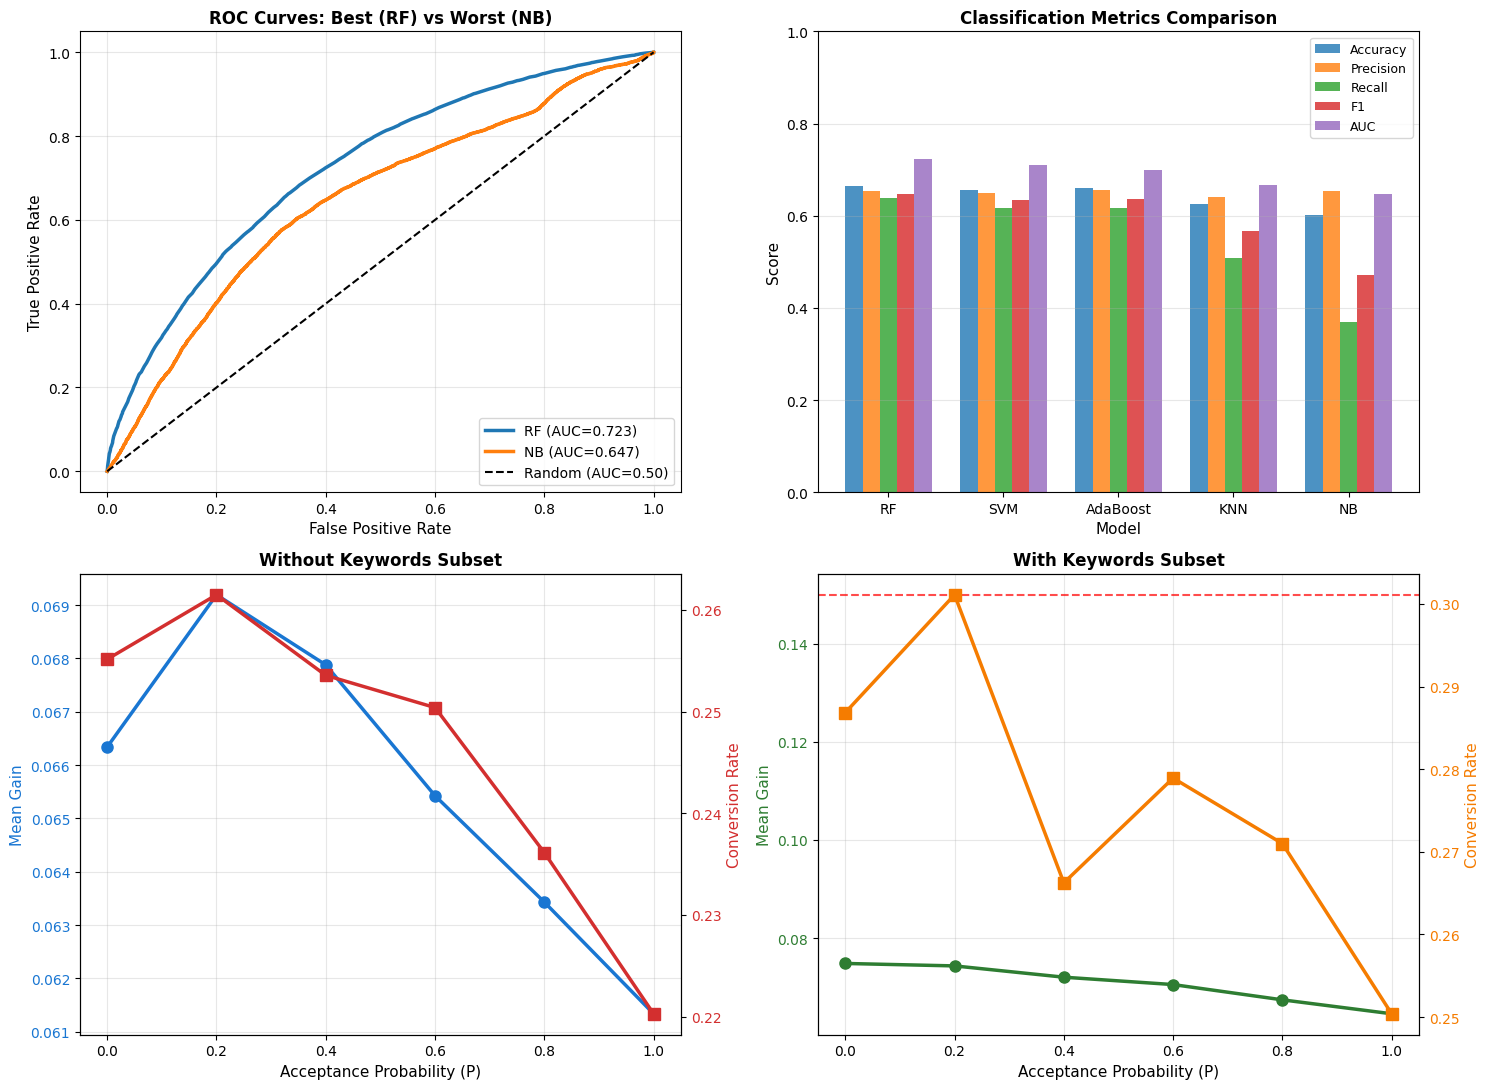

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 11))

### ROC curves
ax = axes[0, 0]
for model_name in ['RF', 'NB']:
    if model_name in all_predictions and len(all_predictions[model_name]['y_true']) > 0:
        y_true = np.array(all_predictions[model_name]['y_true'])
        y_proba = np.array(all_predictions[model_name]['y_proba'])
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc = roc_auc_score(y_true, y_proba)
        ax.plot(fpr, tpr, lw=2.5, label=f'{model_name} (AUC={auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (AUC=0.50)')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curves: Best (RF) vs Worst (NB)', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

### Model comparison
ax = axes[0, 1]
models = metrics_df['Model'].values
x_pos = np.arange(len(models))
width = 0.15

for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']):
    values = [metrics_df[metrics_df['Model']==m][metric].values[0] if len(metrics_df[metrics_df['Model']==m]) > 0 else 0 for m in models]
    ax.bar(x_pos + i*width, values, width, label=metric, alpha=0.8)

ax.set_xlabel('Model', fontsize=11)
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Classification Metrics Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos + width * 2)
ax.set_xticklabels(models, fontsize=10)
ax.legend(fontsize=9)
ax.set_ylim([0, 1.0])
ax.grid(alpha=0.3, axis='y')

### Optimization without keywords
ax = axes[1, 0]
p_vals = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
mg_without = [opt_results['without_keywords'][p]['MG'] for p in p_vals]
cr_without = [opt_results['without_keywords'][p]['CR'] for p in p_vals]

ax2 = ax.twinx()
line1 = ax.plot(p_vals, mg_without, 'o-', color='#1976D2', lw=2.5, markersize=8, label='Mean Gain')
line2 = ax2.plot(p_vals, cr_without, 's-', color='#D32F2F', lw=2.5, markersize=8, label='Conv. Rate')

ax.set_xlabel('Acceptance Probability (P)', fontsize=11)
ax.set_ylabel('Mean Gain', fontsize=11, color='#1976D2')
ax2.set_ylabel('Conversion Rate', fontsize=11, color='#D32F2F')
ax.set_title('Without Keywords Subset', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelcolor='#1976D2')
ax2.tick_params(axis='y', labelcolor='#D32F2F')
ax.grid(alpha=0.3)

### Optimization with keywords
ax = axes[1, 1]
mg_with = [opt_results['with_keywords'][p]['MG'] for p in p_vals]
cr_with = [opt_results['with_keywords'][p]['CR'] for p in p_vals]

ax2 = ax.twinx()
line1 = ax.plot(p_vals, mg_with, 'o-', color='#2E7D32', lw=2.5, markersize=8, label='Mean Gain')
line2 = ax2.plot(p_vals, cr_with, 's-', color='#F57C00', lw=2.5, markersize=8, label='Conv. Rate')
ax.axhline(y=0.15, color='red', linestyle='--', lw=1.5, alpha=0.7, label='Paper Target (0.15)')

ax.set_xlabel('Acceptance Probability (P)', fontsize=11)
ax.set_ylabel('Mean Gain', fontsize=11, color='#2E7D32')
ax2.set_ylabel('Conversion Rate', fontsize=11, color='#F57C00')
ax.set_title('With Keywords Subset', fontsize=12, fontweight='bold')
ax.tick_params(axis='y', labelcolor='#2E7D32')
ax2.tick_params(axis='y', labelcolor='#F57C00')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(r'final_complete_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

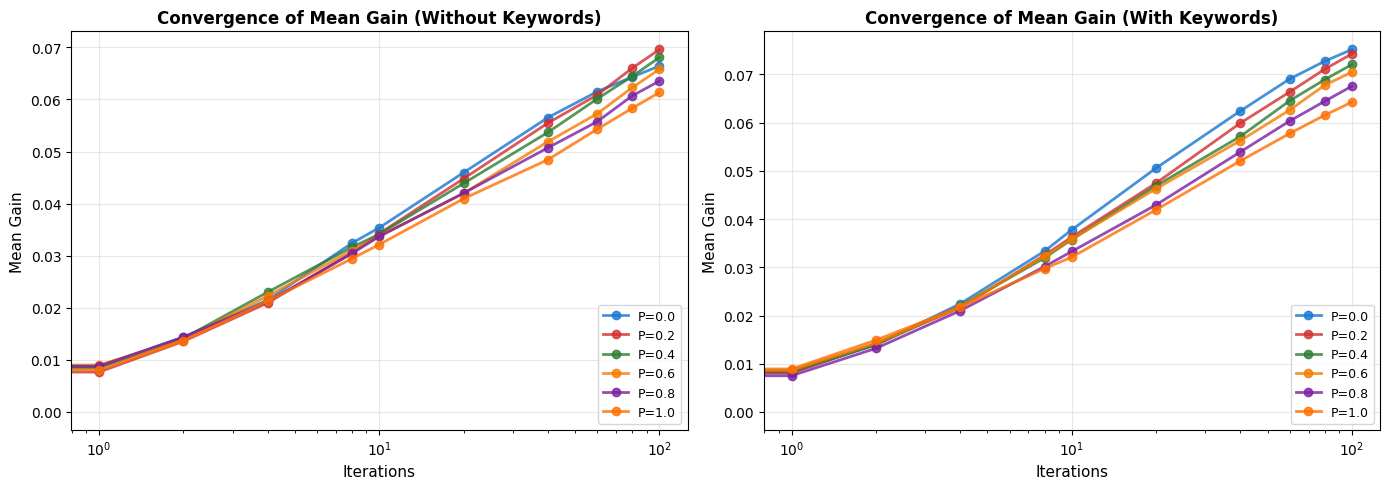

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

### Convergence without keywords
ax = axes[0]
iterations = sorted([i for i in opt_results['without_keywords'][0.0]['iterations'].keys()])
colors_conv = ['#1976D2', '#D32F2F', '#2E7D32', '#F57C00', '#7B1FA2', '#FF6F00']

for p_idx, p in enumerate([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
    convergence = [opt_results['without_keywords'][p]['iterations'].get(i, 0) for i in iterations]
    ax.plot(iterations, convergence, 'o-', color=colors_conv[p_idx], lw=2, label=f'P={p}', alpha=0.8)

ax.set_xlabel('Iterations', fontsize=11)
ax.set_ylabel('Mean Gain', fontsize=11)
ax.set_title('Convergence of Mean Gain (Without Keywords)', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)
ax.set_xscale('log')

### Convergence with keyword
ax = axes[1]
for p_idx, p in enumerate([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
    convergence = [opt_results['with_keywords'][p]['iterations'].get(i, 0) for i in iterations]
    ax.plot(iterations, convergence, 'o-', color=colors_conv[p_idx], lw=2, label=f'P={p}', alpha=0.8)

ax.set_xlabel('Iterations', fontsize=11)
ax.set_ylabel('Mean Gain', fontsize=11)
ax.set_title('Convergence of Mean Gain (With Keywords)', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig(r'convergence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

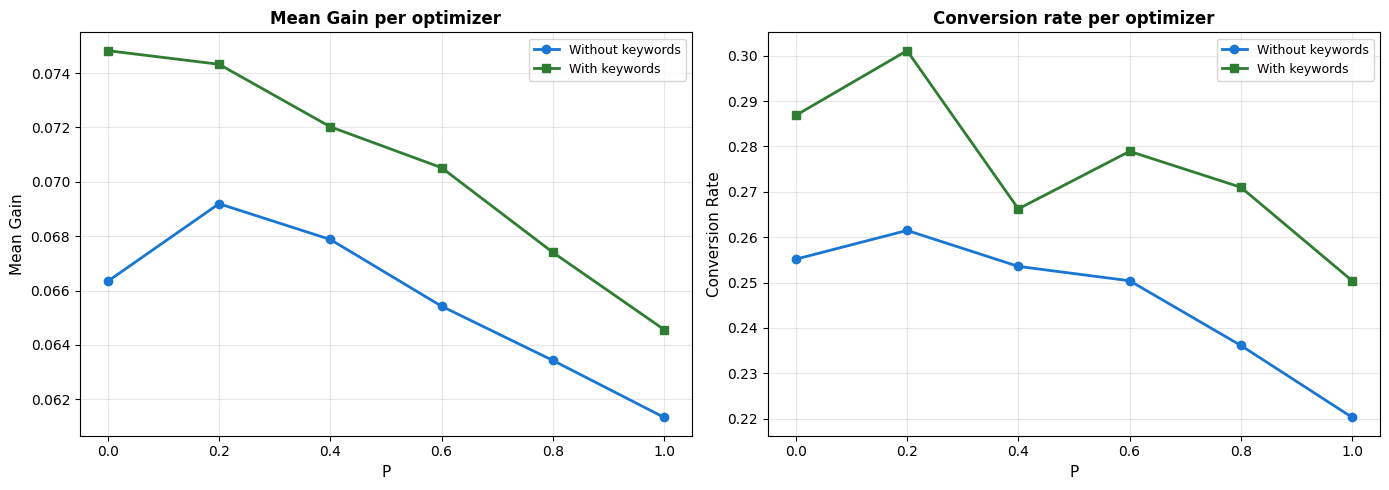

In [ ]:
p_vals = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

mg_without = [opt_results['without_keywords'][p]['MG'] for p in p_vals]
cr_without = [opt_results['without_keywords'][p]['CR'] for p in p_vals]

mg_with = [opt_results['with_keywords'][p]['MG'] for p in p_vals]
cr_with = [opt_results['with_keywords'][p]['CR'] for p in p_vals]

### Mean Gain
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
ax.plot(p_vals, mg_without, 'o-', lw=2, color='#1976D2', label='Without keywords')
ax.plot(p_vals, mg_with, 's-', lw=2, color='#2E7D32', label='With keywords')

ax.set_xlabel('P', fontsize=11)
ax.set_ylabel('Mean Gain', fontsize=11)
ax.set_title('Mean Gain per optimizer', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=9)

### Conversion Rate
ax = axes[1]
ax.plot(p_vals, cr_without, 'o-', lw=2, color='#1976D2', label='Without keywords')
ax.plot(p_vals, cr_with, 's-', lw=2, color='#2E7D32', label='With keywords')

ax.set_xlabel('P', fontsize=11)
ax.set_ylabel('Conversion Rate', fontsize=11)
ax.set_title('Conversion rate per optimizer', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()